# Precomputation of exposure integral

Now that we implement the effective area as a function of energy and zenith angle, can keep the fit fast by precomputing the exposure factor for each source. This is possible if assuming *known* source positions and redshifts.

For now, we assume that the background has some fixed redshift. This is necessary in order to compute the energy losses in the simulation. This is something that will probably be changed in the next step as we include selection effects and try to do something more realistic. 

## What is the exposure integral?

As part of the simulation and fit, we want to compute the expected number of detected neutrinos from each source component. This can be written as $\bar{N}_k = F_k \epsilon_k$ where $F_k = \frac{Q}{4 \pi d_l(z_k)^2}$ and the exposure factor is 
$$
\epsilon_k = T \frac{(\alpha-1)}{E_{\rm{min}}} \int_{E_{\rm{min}}}^\infty {\rm{d}}E \ A_{\rm{eff}}(E, \varpi_k) 
\Bigg( \frac{(1+z_k)E}{E_{\rm{min}}} \Bigg)^{-\alpha} = T \frac{(\alpha-1)}{E_{\rm{min}}} I_k, 
$$
where $k$ is the index for each source (see likelihood derivation for details).

Here we will compute $I_k$ for a range of $\alpha$ so that we can perform fast linear interpolation in the fit for unknown $\alpha$.

### Background case

For the background component, we integrate over the full sky instead of a delta function.

$$
\epsilon_{\rm{bg}} = T \frac{(\alpha-1)}{E_{\rm{min}}} \frac{2 \pi}{4 \pi} \int_{-1}^{1} d(\cos{z}) \ \int_{E_{\rm{min}}}^\infty {\rm{d}}E \ A_{\rm{eff}}(E, \cos{z}) 
\Bigg( \frac{(1+z_{\rm{bg}})E}{E_{\rm{min}}} \Bigg)^{-\alpha} = T \frac{(\alpha-1)}{E_{\rm{min}}} I_{\rm{bg}}, 
$$

where the $2 \pi$ is from integration over $\phi$ in sperical coordinates and $4 \pi$ is from  the vMF distribution in the isotropic case.

### Including threshold effects

We should add a factor of $P(\hat{E} > E_{\rm{th}} | E)$ into the integrands above, and reduce the lower bound of the integral over $E$ accordingly. To simplify, can assume the effective area is 0 below $10^3$ GeV.


In [1]:
import numpy as np
import h5py
from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Effective area

Use the module provided by Martin & Hans to produce a spline with scipy (same code, just a few edits to run in python 3).

In [2]:
from aeff_calculator.aeff_calculator import effective_area

aeff = effective_area("nue_CC")

... creating effective area spline for interaction nue_CC , done!


### Sources

Use a set of sources sampled as having redshift uniform in comoving volume for a $\Lambda CDM$ universe.

In [3]:
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift zth to mimic catalogue
zth = 1
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])

# Add background redshift
source_redshift = list(redshift) 
bg_redshift = zth

### Computation

In [4]:
from exposure_integral import ExposureIntegral

/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
# Define minimum energy
Emin = 1.0E4 # GeV
filename = 'data/precomputed_integral_1e4_100_nouncert_testbound.h5'

exposure_integral = ExposureIntegral(source_redshift, position, bg_redshift, 
                                     aeff, Emin,
                                     filename=filename,
                                     n_points=100)#, f_E=0.5)

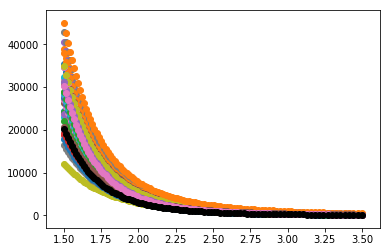

In [6]:
fig, ax = plt.subplots()
for I_k in exposure_integral.integral_grid[:-1]:
    ax.scatter(exposure_integral.alpha_grid, I_k)
ax.scatter(exposure_integral.alpha_grid, exposure_integral.integral_grid[-1], 
           color='k')

## Testing 

In [ ]:
from scipy import integrate
from scipy.stats import lognorm

In [ ]:
AEFF_EMIN = 1e3
AEFF_EMAX = 1e7

def _source_integrand_th(E, position, z, alpha, Emin, f_E):
    """
    Integrand for point sources, including energy threshold
    effects.
    """

    log10E = np.log10(E)
    cosz = unit_vector_to_cosz(position)
    Aeff = np.power(10, aeff.eval(log10E, cosz)[0][0]) # m^2
    p_gt_th = 1-lognorm.cdf(Emin, f_E, 0, E)

    return  p_gt_th * Aeff * ( ((1+z)*E) / Emin )**(-alpha)

def _bg_integrand_th(E, cosz, z, alpha, Emin, f_E):
    """
    Integrand for isotropic background at a certain redshift,
    including energy threshold effects.
    """

    log10E = np.log10(E) # GeV
    Aeff = np.power(10, aeff.eval(log10E, cosz)[0][0])
    p_gt_th = 1-lognorm.cdf(Emin, f_E, 0, E)

    return p_gt_th * Aeff * ( ((1+z)*E) / Emin )**(-alpha)

def unit_vector_to_cosz(unit_vector):
    """
    Convert 3D unit vector to cos(zenith) value.
    """
    return np.cos(np.pi - np.arccos(unit_vector[2]))

In [ ]:
z = bg_redshift
p = position[0]
alpha = 2.0
Emin = 1e4
f_E = 0.5

I = []
integ, err = integrate.dblquad(_bg_integrand_th, -1, 1,
                               lambda E: AEFF_EMIN, lambda E: AEFF_EMAX,
                               args=(z, alpha, Emin, f_E))
#for alpha in np.linspace(1, 4):
    #integ, err = integrate.quad(_source_integrand_th, AEFF_EMIN, AEFF_EMAX,
    #                            args=(p, z, alpha, Emin, f_E))

    #I.append(integ)

In [ ]:
print(integ*0.5)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(np.linspace(1, 4), I)
ax.plot(exposure_integral.alpha_grid, exposure_integral.integral_grid[-1])
ax.axvline(2)
ax.axhline(3531)
ax.set_ylim(0, 1e4)